In [1]:
# 📚 Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os

--- Chargement des assets ---
✅ Données, Modèle 1 et sa structure de colonnes chargés.

--- Préparation des données pour le Modèle 1 ---
Structure de référence chargée : 42 colonnes attendues.
Colonnes générées avant reindex : 40
Colonnes après reindex (doit correspondre à l'entraînement) : 42
✅ Score de risque calculé.

--- Création des variables pour le Modèle 2 ---

--- Entraînement du Modèle 2 (Hybride) ---
✅ Modèle 2 (Hybride) entraîné.

--- Performance du Modèle 2 Hybride ---
Accuracy: 0.4660
              precision    recall  f1-score   support

           A       0.65      0.58      0.61     12159
           B       0.48      0.63      0.55     22043
           C       0.40      0.45      0.43     19732
           D       0.39      0.24      0.30     11504
           E       0.37      0.25      0.30      5684
           F       0.28      0.03      0.05      1903
           G       0.02      0.01      0.02       218

    accuracy                           0.47     73243
   macro

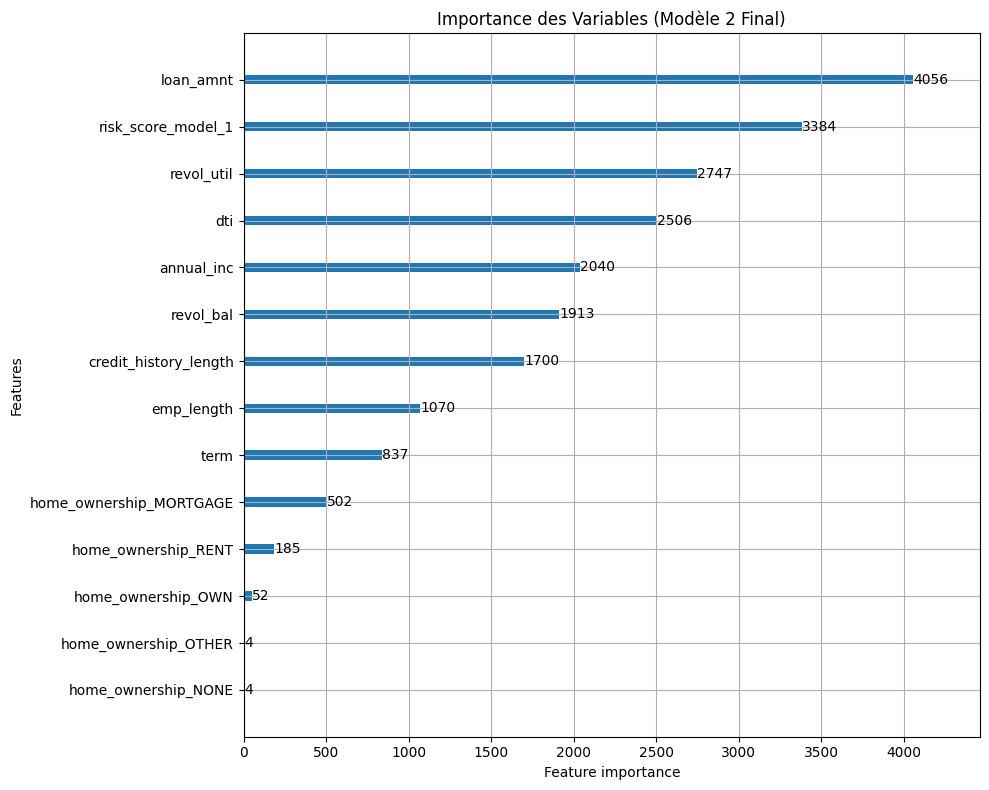


✅ Modèle 2 sauvegardé dans : ../../models/pricing_model_grade_prediction_final.pkl
✅ Encodeur de Grade sauvegardé dans : ../../models/grade_label_encoder.pkl
✅ Colonnes du Modèle 2 sauvegardées dans : ../../models/model_2_columns.pkl


In [2]:
# ==============================================================================
# 📂 Étape 1 : Chargement des Données et des "Assets" du Modèle 1
# ==============================================================================
print("--- Chargement des assets ---")

# --- Chemins (à vérifier) ---
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
model_1_path = "../../models/model_risk_of_default.pkl"
model_1_cols_path = "../../models/model_1_columns.pkl" # Fichier crucial à avoir
output_dir = "../../models/"

# --- Création du dossier de sortie si besoin ---
os.makedirs(output_dir, exist_ok=True)
model_2_path = os.path.join(output_dir, "pricing_model_grade_prediction_final.pkl")
encoder_path = os.path.join(output_dir, "grade_label_encoder.pkl")
model_2_cols_path = os.path.join(output_dir, "model_2_columns.pkl")


# --- Chargement ---
df = pd.read_parquet(input_path)
model_1 = joblib.load(model_1_path)
model_1_training_columns = joblib.load(model_1_cols_path)
print("✅ Données, Modèle 1 et sa structure de colonnes chargés.")


# ==============================================================================
# ⚙️ Étape 2 : Préparation des données et Calcul du Score de Risque
# ==============================================================================
print("\n--- Préparation des données pour le Modèle 1 ---")

# 2.1 Chargement de la structure de colonnes sauvegardée
model_1_training_columns = joblib.load("../../models/model_1_columns.pkl")
print(f"Structure de référence chargée : {len(model_1_training_columns)} colonnes attendues.")

# 2.2 Préparation des données pour la prédiction
features_to_exclude_for_model_1 = [
    'loan_status', 'is_default', 'id',
    'grade', 'sub_grade', 'int_rate', 'installment', 'last_pymnt_d',
    'emp_title', 'emp_title_clean', 'title', 'zip_code',
    'job_category', 'csp_category',
    'issue_d', 'earliest_cr_line'
]
X_for_model_1 = df.drop(columns=features_to_exclude_for_model_1, errors='ignore')
X_for_model_1 = pd.get_dummies(X_for_model_1, drop_first=True, dtype=float)

print(f"Colonnes générées avant reindex : {X_for_model_1.shape[1]}")

# 2.3 Forcer la correspondance des colonnes (la correction "anti-erreur")
# Cette ligne ajoute les colonnes manquantes avec une valeur de 0 et supprime celles en trop.
X_for_model_1 = X_for_model_1.reindex(columns=model_1_training_columns, fill_value=0)

print(f"Colonnes après reindex (doit correspondre à l'entraînement) : {X_for_model_1.shape[1]}")


# 2.4 Calcul du score de risque
risk_probabilities = model_1.predict_proba(X_for_model_1)[:, 1]
df['risk_score_model_1'] = risk_probabilities
print("✅ Score de risque calculé.")

# ==============================================================================
# ✨ Étape 3 : Feature Engineering pour le Modèle 2
# ==============================================================================
print("\n--- Création des variables pour le Modèle 2 ---")
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
# Ajoutez ici d'autres créations de variables si vous le souhaitez


# ==============================================================================
# 🚀 Étape 4 : Entraînement du Modèle 2 (Hybride)
# ==============================================================================
print("\n--- Entraînement du Modèle 2 (Hybride) ---")

# 4.1 Définition de la Cible (Y) et des Features (X)
y = df['grade']
features_for_model_2_hybrid = [
    'risk_score_model_1', 'revol_bal', 'dti', 'revol_util', 'emp_length',
    'home_ownership', 'loan_amnt', 'annual_inc', 'term', 'credit_history_length'
]
X = df[features_for_model_2_hybrid]
X = pd.get_dummies(X, drop_first=True, dtype=float)

# 4.2 Encodage et Séparation
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 4.3 Entraînement
model_2 = lgb.LGBMClassifier(objective='multiclass', random_state=42)
model_2.fit(X_train, y_train)
print("✅ Modèle 2 (Hybride) entraîné.")

# 4.4 Évaluation
y_pred = model_2.predict(X_test)
print(f"\n--- Performance du Modèle 2 Hybride ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))
lgb.plot_importance(model_2, max_num_features=20, figsize=(10, 8), title="Importance des Variables (Modèle 2 Final)")
plt.tight_layout()
plt.show()

# ==============================================================================
# 💾 Étape 5 : Sauvegarde des "Assets" du Modèle 2
# ==============================================================================
joblib.dump(model_2, model_2_path)
joblib.dump(le, encoder_path)
joblib.dump(X.columns.tolist(), model_2_cols_path)
print(f"\n✅ Modèle 2 sauvegardé dans : {model_2_path}")
print(f"✅ Encodeur de Grade sauvegardé dans : {encoder_path}")
print(f"✅ Colonnes du Modèle 2 sauvegardées dans : {model_2_cols_path}")

In [3]:
output_dir = "../../models/"

# Sauvegarde de l'encodeur pour le 'grade'
encoder_path = os.path.join(output_dir, "grade_label_encoder.pkl")
# 'le' doit être le nom de votre variable LabelEncoder dans le notebook
joblib.dump(le, encoder_path) 
print(f"✅ LabelEncoder sauvegardé dans : {encoder_path}")


# Sauvegarde de la liste des colonnes pour chaque modèle
# 'X_for_model_1' et 'X' doivent correspondre aux DataFrames préparés dans votre notebook
model_1_cols_path = os.path.join(output_dir, "model_1_columns.pkl")
joblib.dump(X_for_model_1.columns.tolist(), model_1_cols_path)
print(f"✅ Colonnes du Modèle 1 sauvegardées.")

model_2_cols_path = os.path.join(output_dir, "model_2_columns.pkl")
joblib.dump(X.columns.tolist(), model_2_cols_path)
print(f"✅ Colonnes du Modèle 2 sauvegardées.")

✅ LabelEncoder sauvegardé dans : ../../models/grade_label_encoder.pkl
✅ Colonnes du Modèle 1 sauvegardées.
✅ Colonnes du Modèle 2 sauvegardées.


In [4]:
# À exécuter dans un notebook pour calculer les profils types

# Assurez-vous d'avoir le DataFrame 'df' final, après le calcul du score de risque
# et la création des nouvelles variables.

# Sélection des colonnes pertinentes pour définir un profil
profile_cols = [
    'grade',
    'risk_score_model_1',
    'loan_amnt',
    'annual_inc',
    'dti',
    'revol_bal',
    'revol_util',
    'emp_length',
    'credit_history_length'
]

# Calcul du profil médian pour chaque grade
archetypes = df[profile_cols].groupby('grade').median()

# Affichage des archétypes
print("Profils-types (Archétypes) par Grade :")
display(archetypes)

# Optionnel : Sauvegarder ces archétypes pour les utiliser dans l'app
# archetypes.to_csv('../../models/grade_archetypes.csv')

Profils-types (Archétypes) par Grade :


,risk_score_model_1,loan_amnt,annual_inc,dti,revol_bal,revol_util,emp_length,credit_history_length
grade,,,,,,,,
A,0.443837,12000.0,75000.0,13.290,11822.0,3.72,6.0,5486.0
B,0.591901,12000.0,64000.0,15.050,11484.0,5.35,6.0,5121.0
C,0.671542,12000.0,60000.0,16.230,11007.0,5.87,6.0,5113.0
D,0.743563,12975.0,60000.0,16.870,10743.0,6.23,6.0,5108.0
E,0.774201,16575.0,64000.0,17.640,11921.0,6.37,6.0,5111.0
F,0.802537,19350.0,66740.0,17.540,12185.5,6.61,6.0,5105.0
G,0.755649,21000.0,75000.0,17.205,13789.5,7.21,7.0,5107.5
